In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
from scipy.sparse import diags, eye, kron, bmat, csr_matrix
from scipy.sparse.linalg import eigs

def mround(x):
    """
    Arredondamento no estilo MATLAB: .5 -> sobe.
    Aceita escalar ou array NumPy.
    """
    return np.floor(x + 0.5).astype(int)

def diff_opr(Nx,Ny,dx,dy): #Build the differentiation matrices, f -> backyard e g -> forward
  M = Nx*Ny
  diagonal = np.ones(M-1)
  diagonal[Nx-1:-1:Nx] = 0
  Dxf = -sp.eye(M,M) + sp.diags(diagonal, 1, shape=(M,M))
  Dyf = sp.eye(M,M,k = Nx) - sp.eye(M,M)
  Dxg = -Dxf.conj().T
  Dyg = -Dyf.conj().T
  return Dxf/dx, Dyf/dy, Dxg/dx, Dyg/dy

micrometers = 1e-6

# lambda reference
lam0 = 1.55 * micrometers 

# number of modes
nmodes = 3

In [ ]:
# RIDGE material
n_substrate = 1.5 
n_core = 3.5

# RIDGE dimensionS

ridge_h = 0.22 * micrometers
ridge_w = 0.45 * micrometers

# Extra space
SPACER = micrometers * np.array([1, 1, 1, 1])  # [sx_left, sx_right, sy_bottom, sy_top]

In [ ]:
# Grid parameters
nmax   = max(n_substrate, n_core)
NRES   = 30 # Resoltion of the wavelength

In [ ]:
dx = lam0 / nmax / NRES 
dy = lam0 / nmax / NRES 
print("dx = %.5e - dy = %.5e"%(dx, dy))

dx = 1.47619e-08 - dy = 1.47619e-08


# Cálculo da Malha #

In [124]:
# Adjust Mesh

nx = int(np.ceil(ridge_w / dx)) # Number of points required to discretize the core length
dx = ridge_w / nx # Adjust dx 
ny = int(np.ceil(ridge_h / dy)) # Number of points required to discretize the core height
dy = ridge_h / ny # Adjust dy
print("nx = %d - ny = %d"%(nx, ny))
print("dx = %.5e - dy = %.5e"%(dx, dy))

nx = 31 - ny = 15
dx = 1.45161e-08 - dy = 1.46667e-08


In [ ]:
# Grid size X
Sx = SPACER[0] + ridge_w + SPACER[1]
Nx = int(np.ceil(Sx / dx))
Sx = Nx * dx

# Grid size Y
Sy = SPACER[2] + ridge_h + SPACER[3]
Ny = int(np.ceil(Sy / dy))
Sy = Ny * dy
print("Total size (Nx x Ny) = %d x %d"%(Nx,Ny)) 
print("Total size (Sx x Sy) = %.3g [um] x %.3g [um]"%(1e6*Sx,1e6*Sy)) 

# Grid - upsample (2x) 
Nx2 = 2 * Nx; dx2 = dx / 2
Ny2 = 2 * Ny; dy2 = dy / 2

# Grid axes
xa  = np.arange(1, Nx + 1) * dx;  xa  = xa  - xa.mean()
ya  = np.arange(1, Ny + 1) * dy;  ya  = ya  - ya.mean()

# Upsample grid (2x)
xa2 = np.arange(1, Nx2 + 1) * dx2; xa2 = xa2 - xa2.mean()
ya2 = np.arange(1, Ny2 + 1) * dy2; ya2 = ya2 - ya2.mean()

# Create meshgrid
Yc, Xc = np.meshgrid(ya2, xa2, indexing="xy") 

Total size (Nx x Ny) = 169 x 152
Total size (Sx x Sy) = 2.45 [um] x 2.23 [um]


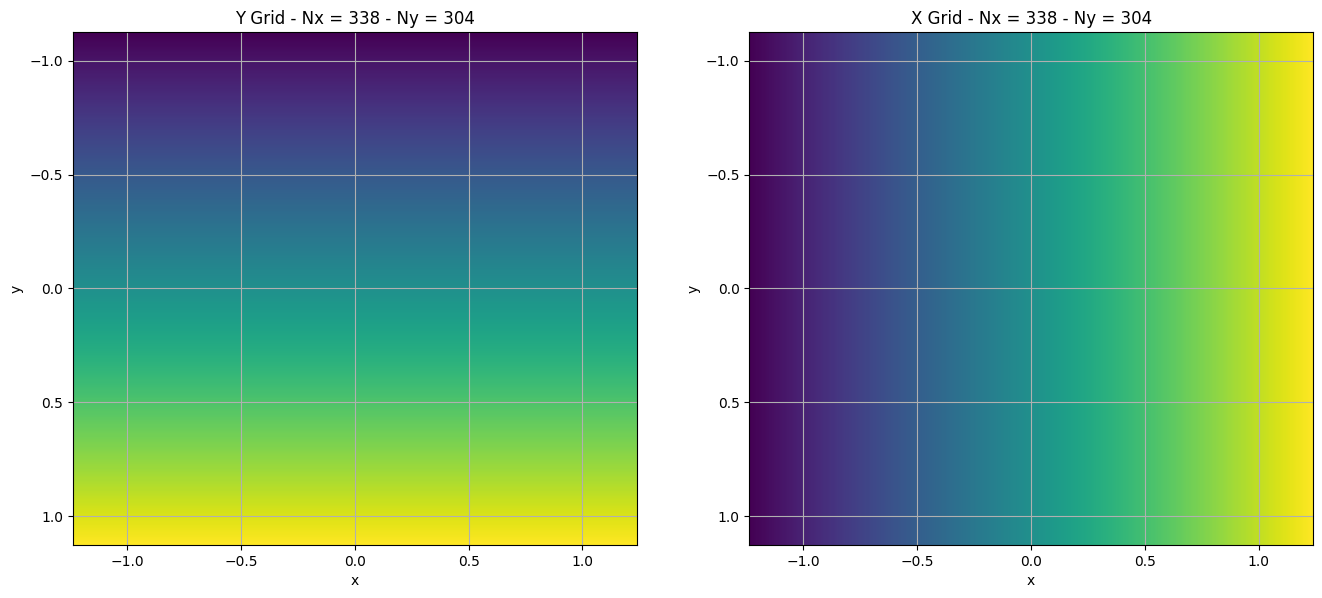

<Figure size 640x480 with 0 Axes>

In [126]:
fig, ax = plt.subplots(1, 2, figsize=(16, 10))

ext = 1e6*np.array([xa2.min()-dx, xa2.max()+dx, ya2.max()+dy, ya2.min()-dy])

ax[0].imshow(Yc.T, extent=ext, aspect="equal")
ax[0].set(xlabel="x", ylabel="y", title=f"{"Y Grid"} - Nx = {Nx2} - Ny = {Ny2}")
ax[0].grid()

ax[1].imshow(Xc.T, extent=ext, aspect="equal")
ax[1].set(xlabel="x", ylabel="y", title=f"{"X Grid"} - Nx = {Nx2} - Ny = {Ny2}")
ax[1].grid()

plt.show()
plt.tight_layout()

In [127]:
# Creatre relative permeability matrices

ER2 = (n_substrate**2) * np.ones((Nx2, Ny2))
UR2 = np.ones((Nx2, Ny2))

# Create subintervals

nx1 = int(mround(SPACER[0] / dx2))
nx2 = nx1 + int(mround(ridge_w / dx2))

ny1 = int(mround(SPACER[2] / dy2))
ny2 = ny1 + int(mround(ridge_h / dy2))

# Making the core

ER2[nx1:nx2, ny1:ny2] = n_core**2

print(Nx2 * dx2)

2.453225806451613e-06


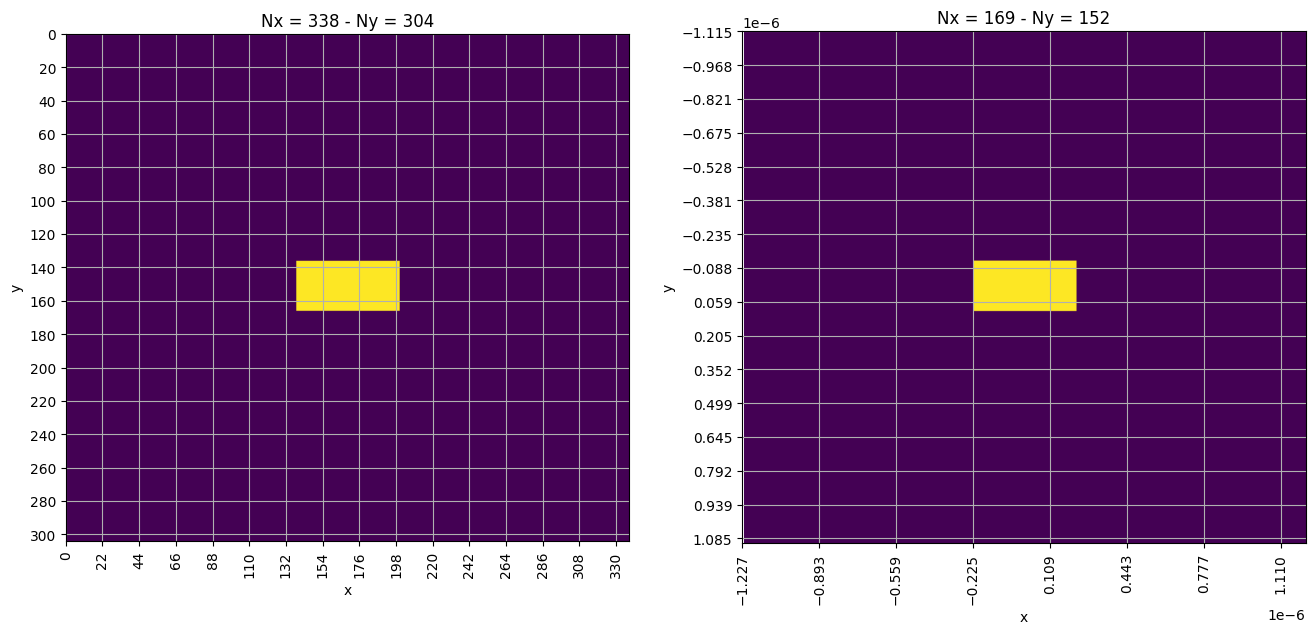

'\nNa matriz, preenchemos as informações do eixo x e y normalmente, só temos que lembrar de transpolas depois.\n'

<Figure size 640x480 with 0 Axes>

In [128]:
fig, ax = plt.subplots(1,2,figsize=(16, 8))

ax[0].imshow(ER2.T, extent=[0, Nx2, Ny2, 0], aspect="equal")
ax[0].set(xlabel="x", ylabel="y", title=f"Nx = {Nx2} - Ny = {Ny2}")
ax[0].set_xticks(np.arange(0, Nx2 + 1, 22))
ax[0].set_yticks(np.arange(0, Ny2 + 1, 20))
ax[0].tick_params(axis='x', labelrotation=90)
ax[0].grid(which='both')

ax[1].imshow(ER2.T, extent=np.array([xa.min(), xa.max(), ya.max(), ya.min()]), aspect="equal")
ax[1].set(xlabel="x", ylabel="y", title=f"Nx = {Nx} - Ny = {Ny}")
ax[1].set_xticks(np.arange(xa.min()-dx/2, xa.max()+dx, 23*dx))
ax[1].set_yticks(np.arange(ya.min()-dy/2, ya.max()+dy, 10*dy))
#ax[1].plot(Xc.ravel(), Yc.ravel(), marker="o", linestyle="None", markersize=2)
ax[1].tick_params(axis='x', labelrotation=90)
ax[1].grid(which='both')

plt.show()
plt.tight_layout()

'''
Na matriz, preenchemos as informações do eixo x e y normalmente, só temos que lembrar de transpolas depois.
'''

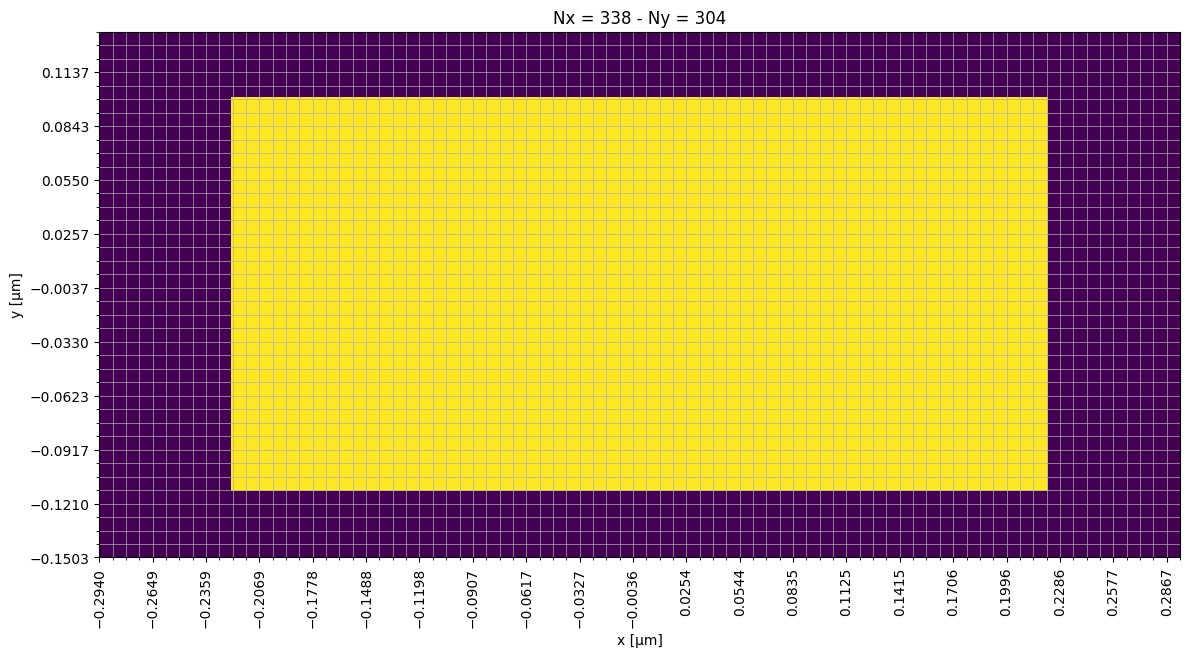

In [ ]:
from matplotlib.ticker import ScalarFormatter

zoomx = 10
zoomy = 5
x_zoom = 1e6*xa2[(nx1-zoomx):(nx2+zoomx)]
y_zoom = 1e6*ya2[(ny1-zoomy):(ny2+zoomy)]

xmin, xmax = x_zoom.min(), x_zoom.max()
ymin, ymax = y_zoom.min(), y_zoom.max()

stepx = 1e6*dx2   
stepy = 1e6*dy2   

xticks_all = np.arange(xmin, xmax + 0.5*stepx, stepx)
yticks_all = np.arange(ymin, ymax + 0.5*stepy, stepy)
xticks_major = xticks_all[::4]
yticks_major = yticks_all[::4]

fig, ax = plt.subplots(figsize=(12, 12))

ax.imshow(
    ER2[(nx1-zoomx):(nx2+zoomx), (ny1-zoomy):(ny2+zoomy)].T,
    extent=[xmin, xmax, ymin, ymax],
    aspect="equal"
)

ax.set(xlabel="x [µm]", ylabel="y [µm]", title=f"Nx = {Nx2} - Ny = {Ny2}")

# define majors (with label) and minors (without label)
ax.set_xticks(xticks_major)              # majors
ax.set_xticks(xticks_all, minor=True)    # minors (grade densa)

ax.set_yticks(yticks_major)
ax.set_yticks(yticks_all, minor=True)

# formatação dos labels
ax.tick_params(axis='x', labelrotation=90)
ax.xaxis.set_major_formatter(ScalarFormatter(useOffset=False))
ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))

ax.grid(which='both', linewidth=0.5)
# (opcional) estilos diferentes:
# ax.grid(which='major', linewidth=0.8)
# ax.grid(which='minor', linewidth=0.3, alpha=0.6)

plt.tight_layout()
plt.show()

In [130]:
ERxx = ER2[1::2, 0::2]
ERyy = ER2[0::2, 1::2]
ERzz = ER2[0::2, 0::2]

URxx = UR2[0::2, 1::2]
URyy = UR2[1::2, 0::2]
URzz = UR2[1::2, 1::2]

M = ERxx.size
assert M == (Nx * Ny), "Inconsistência entre tamanhos da malha e subamostragem Yee."

def diag_from_grid(G):
    return diags(G.reshape(-1, order='F'), 0, shape=(M, M), format='csr')

ERxx = diag_from_grid(ERxx)
ERyy = diag_from_grid(ERyy)
ERzz = diag_from_grid(ERzz)

URxx = diag_from_grid(URxx)
URyy = diag_from_grid(URyy)
URzz = diag_from_grid(URzz)

In [131]:
k0 = 2*np.pi/lam0
# Dif. Operators
DEX, DEY, DHX, DHY = diff_opr(Nx,Ny,dx,dy)
# Norm
DEX = DEX/k0
DEY = DEY/k0
DHX = DHX/k0
DHY = DHY/k0

In [132]:
def inv_diag(diag_mat: csr_matrix) -> csr_matrix:
    """Retorna a inversa de uma matriz diagonal esparsa (CSR)."""
    d = diag_mat.diagonal()
    return diags(1.0 / d, format='csr')

In [133]:
ERzz_inv = inv_diag(ERzz)
URzz_inv = inv_diag(URzz)

In [ ]:
P11 = DEX @ ERzz_inv @ DHY
P12 = -(DEX @ ERzz_inv @ DHX + URyy)
P21 = DEY @ ERzz_inv @ DHY + URxx
P22 = -(DEY @ ERzz_inv @ DHX) 

P = bmat([[P11, P12],
          [P21, P22]], format='csr')

Q11 = DHX @ URzz_inv @ DEY
Q12 = -(DHX @ URzz_inv @ DEX + ERyy)
Q21 = DHY @ URzz_inv @ DEY + ERxx
Q22 = -(DHY @ URzz_inv @ DEX)

Q = bmat([[Q11, Q12],
          [Q21, Q22]], format='csr')

# EIGENVALUE PROBLEM
A = (P @ Q).tocsr()
ev_target = - (n_core**2)    # Target eigenvalue

vals, Exy = eigs(A, k=nmodes, sigma=ev_target)
d = np.sqrt(vals)
NEFF = np.imag(d)

In [135]:
NEFF

array([2.39836842, 1.81068128, 1.50626233])

In [136]:
Ex = Exy[:M, :]
Ey = Exy[M:2*M, :]

Hxy = Q @ Exy
Hxy = Hxy @ diags(-1.0/d, format='csr')

Hx = Hxy[:M, :]
Hy = Hxy[M:2*M, :]

# Ez and Hz calculation

Ez = URzz_inv @ (DHX @ Hy - DHY @ Hx)
Hz = URzz_inv @ (DEX @ Ey - DEY @ Ex)

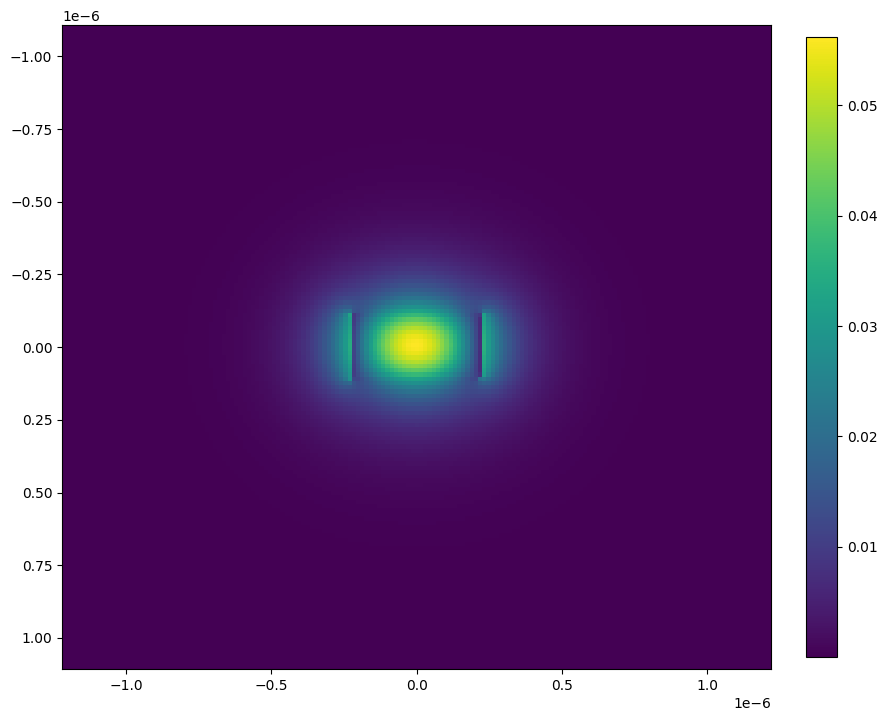

In [ ]:
ex_lin = np.reshape(Ex[:,0], (Nx, Ny), order='F')
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(np.real(ex_lin.T), extent=np.array([xa.min(), xa.max(), ya.max(), ya.min()]), aspect="equal", cmap = "viridis")
cbar = plt.colorbar(im, ax=ax, fraction=0.04, pad=0.045)

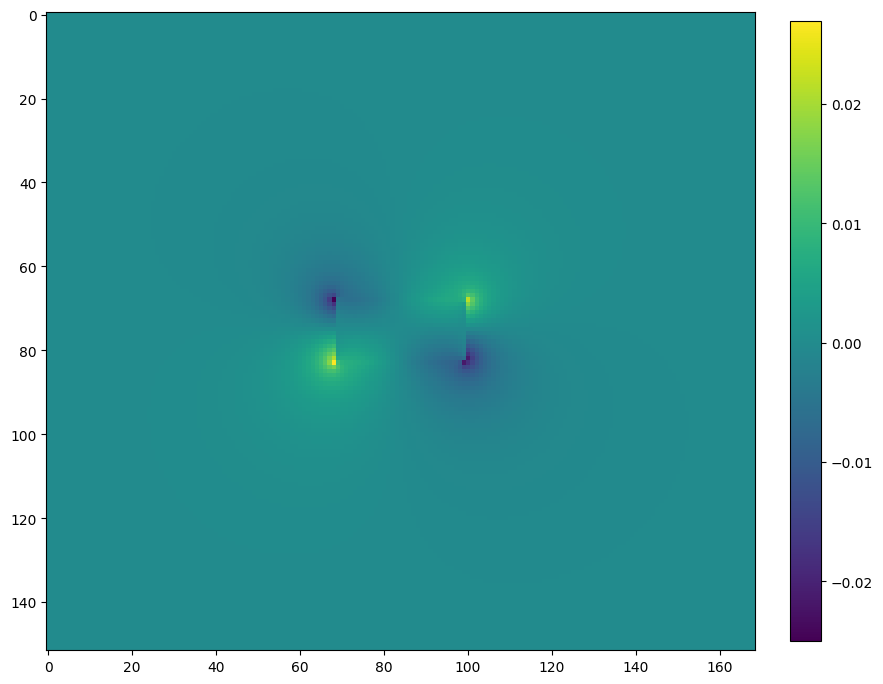

In [138]:
ex = Ex[:, 1].reshape((Nx, Ny), order='F')
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(np.real(ex.T), cmap="viridis")
cbar = plt.colorbar(im, ax=ax, fraction=0.04, pad=0.045)

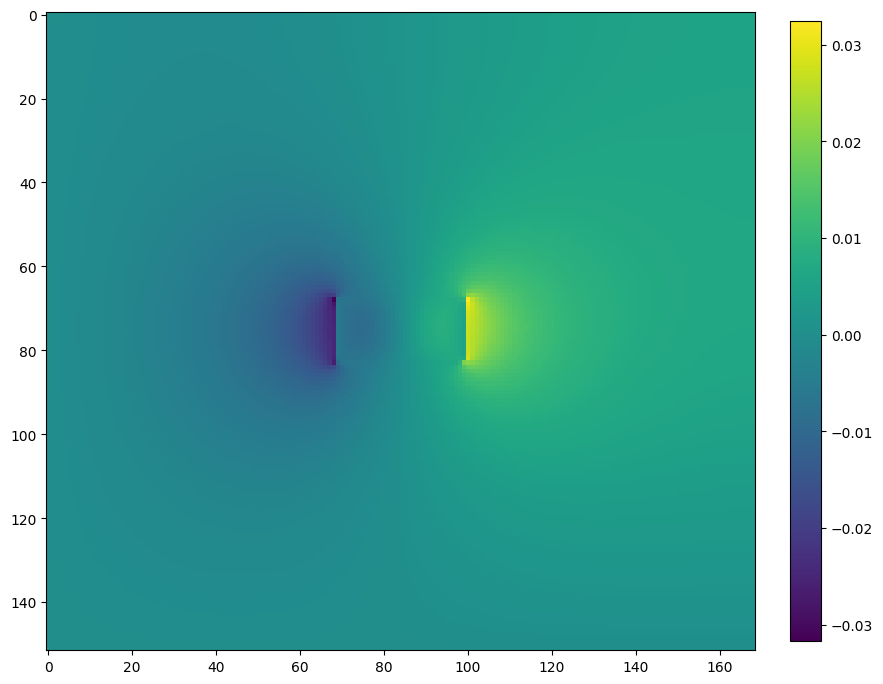

In [139]:
ex = Ex[:, 2].reshape((Nx, Ny), order='F')
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(np.real(ex.T), cmap="viridis")
cbar = plt.colorbar(im, ax=ax, fraction=0.04, pad=0.045)